In [1]:
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.nn as nn
import numpy as np
import os, json
from google.colab import drive
from torchvision import models, transforms
from torch.autograd import Variable
from PIL import Image
from skimage.segmentation import mark_boundaries

In [2]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [3]:
!pip install memory_profiler

  Created wheel for memory-profiler: filename=memory_profiler-0.58.0-cp37-none-any.whl size=30180 sha256=2e6060fa9399e2385d6d344f4ec822afa755e7d3f3a168e04cd2484ebf77c0eb
  Stored in directory: /root/.cache/pip/wheels/02/e4/0b/aaab481fc5dd2a4ea59e78bc7231bb6aae7635ca7ee79f8ae5
Successfully built memory-profiler


In [4]:
%load_ext memory_profiler

## Import depedences from google drive

In [5]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [7]:
%cd '/content/gdrive/My Drive/UnB/TCC-1/TCC1-1-dataset-final'

/content/gdrive/My Drive/UnB/TCC-1/TCC1-1-dataset-final


In [8]:
!ls

cm_data_set_exp1.png  intrepretabilidade_results	skin.txt
dataset_final	      main.py				train_val_phase.csv
dataset_final.tar.xz  __pycache__
grad_cam.py	      restnet_model152_trained_exp7.pt


## Download lime with pip

In [9]:
!pip install lime

     |████████████████████████████████| 276kB 8.4MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-cp37-none-any.whl size=283846 sha256=6b3d76180313ede95788cdd958f26fe0ce0660249c7f5df9ad38170aae66bcdc
  Stored in directory: /root/.cache/pip/wheels/4c/4f/a5/0bc765457bd41378bf3ce8d17d7495369d6e7ca3b712c60c89
Successfully built lime


In [10]:
from lime import lime_image

## Using Lime with Pytorch

Based on a oficial repo's notebook

Image preview 

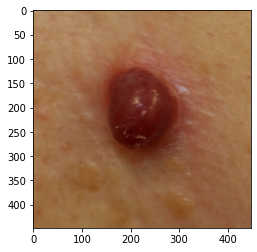

In [36]:
def get_image(path):
    with open(os.path.abspath(path), 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB') 
        
img = get_image('/content/gdrive/My Drive/UnB/TCC-1/TCC1-1-dataset-final/dataset_final/test/pyogenic-granuloma/1338.jpg')
plt.imshow(img)

We need to convert this image to Pytorch tensor and also apply transformations in order to feed our pretrained model

In [37]:
def get_input_transform():
  '''
  Pre transformations applied on the image
  '''
  normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])       
  transf = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        normalize
    ])    

  return transf

def get_input_tensors(img):
  '''
  Convert image to feed the model
  '''
  transf = get_input_transform()
  # unsqeeze converts single image to batch of 1
  return transf(img).unsqueeze(0)

### Load the skin lession model

In [38]:
PRE_MODEL_DIR='/content/gdrive/My Drive/UnB/TCC-1/TCC1-1-dataset-final/restnet_model152_trained_exp7.pt'

In [39]:
model_name='resnet'
num_classes = 9
feature_extract = False

In [40]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False


In [41]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet152
        """
        model_ft = models.resnet152(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    else:
        print("Invalid model name, exiting...")
        exit()
    
    return model_ft, input_size

# Initialize the model for this run
model, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

In [42]:
if train_on_gpu:
    state = torch.load(PRE_MODEL_DIR)
else:
    state = torch.load(PRE_MODEL_DIR, map_location='cpu')

# Loading weights in restnet architecture
model.load_state_dict(state['state_dict'])

<All keys matched successfully>

In [43]:
classes_skin = state['class_to_idx']
classes_skin

{'actinic-keratosis': 0,
 'basal-cell-carcinoma': 1,
 'dermatofibroma': 2,
 'hemangioma': 3,
 'intraepithelial-carcinoma': 4,
 'malignant-melanoma': 5,
 'melanocytic-nevus': 6,
 'pyogenic-granuloma': 7,
 'squamous-cell-carcinoma': 8}

In [44]:
classes_skin = { "0": ['n09246464','actinic-keratosis'],
  "1": ['n09246465','basal-cell-carcinoma'],
  "2": ['n09246468','dermatofibroma'],
  "3": ['n09246467','hemangioma'],
  "4": ['n09246468','intraepithelial-carcinoma'],
  "5": ['n09246469','malignant-melanoma'],
  "6": ['n09246470','melanocytic-nevus'],
  "7": ['n09246471','pyogenic-granuloma'],
  "8": ['n09246472','squamous-cell-carcinoma']}

In [45]:
idx2label = [] 
cls2label = {}
cls2idx = {}

idx2label = [classes_skin[str(k)][1] for k in range(len(classes_skin))]
cls2label = {classes_skin[str(k)][0]: classes_skin[str(k)][1] for k in range(len(classes_skin))}
cls2idx = {classes_skin[str(k)][0]: k for k in range(len(classes_skin))}

In [46]:
img_t = get_input_tensors(img)
model.eval()
logits = model(img_t)

In [47]:
probs = F.softmax(logits, dim=1)
probs5 = probs.topk(5)
tuple((p,c, idx2label[c]) for p, c in zip(probs5[0][0].detach().numpy(), probs5[1][0].detach().numpy()))

((0.99997437, 7, 'pyogenic-granuloma'),
 (1.743112e-05, 3, 'hemangioma'),
 (5.303583e-06, 8, 'squamous-cell-carcinoma'),
 (1.734902e-06, 6, 'melanocytic-nevus'),
 (6.6320933e-07, 1, 'basal-cell-carcinoma'))

In [48]:
def get_pil_transform(): 
    transf = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224)
    ])    

    return transf

def get_preprocess_transform():
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])     
    transf = transforms.Compose([
        transforms.ToTensor(),
        normalize
    ])    

    return transf    

pill_transf = get_pil_transform()
preprocess_transform = get_preprocess_transform()

In [49]:
def batch_predict(images):
    model.eval()
    batch = torch.stack(tuple(preprocess_transform(i) for i in images), dim=0)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    batch = batch.to(device)
    
    logits = model(batch)
    probs = F.softmax(logits, dim=1)
    return probs.detach().cpu().numpy()

In [50]:
test_pred = batch_predict([pill_transf(img)])
test_pred.squeeze().argmax()

7

In [51]:
test_pred

array([[9.6526465e-10, 6.2509048e-07, 3.8785296e-07, 1.4221121e-05,
        5.7750196e-09, 9.6417075e-08, 4.2829442e-06, 9.9997568e-01,
        4.7711533e-06]], dtype=float32)

In [52]:
from lime.wrappers.scikit_image import SegmentationAlgorithm
explainer = lime_image.LimeImageExplainer(verbose = True)
# segmenter = SegmentationAlgorithm('slic', n_segments=100, compactness=1, sigma=1)
# segmenter = SegmentationAlgorithm('quickshift', kernel_size=1, max_dist=200, ratio=0.2)

In [53]:
import time

In [54]:
%%time

# explainer = lime_image.LimeImageExplainer()
%memit  
explanation = explainer.explain_instance(np.array(pill_transf(img)),
                                                batch_predict, # classification function
                                                top_labels=5,
                                                hide_color=None, 
                                                num_samples=1000) # number of images that will be sent to classification function
%memit                                          

peak memory: 3884.75 MiB, increment: 0.00 MiB



Intercept 0.0014124485062205743
Prediction_local [-0.00032235]
Right: 6.2508576e-07
Intercept 0.057103399153390313
Prediction_local [-0.03543618]
Right: 4.2829192e-06
Intercept 0.0010578926753590542
Prediction_local [0.00010952]
Right: 4.771126e-06
Intercept 0.3104818255435867
Prediction_local [-0.18285079]
Right: 1.4221053e-05
Intercept 0.586988255331319
Prediction_local [1.2454379]
Right: 0.9999757
peak memory: 3884.82 MiB, increment: 0.01 MiB
CPU times: user 9.51 s, sys: 3.34 s, total: 12.9 s
Wall time: 13.1 s


In [55]:
explanation.score

0.43272741979133916

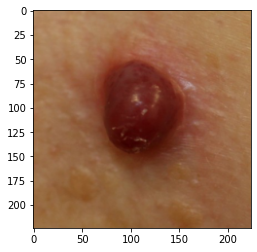

In [56]:
plt.imshow(explanation.image)

Let's use mask on image and see the areas that are encouraging the top prediction.

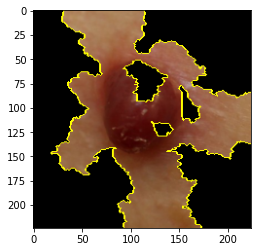

In [57]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=10, hide_rest=True)
img_boundry1 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry1)

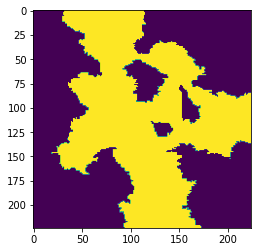

In [58]:
plt.imshow(mask)

Let's turn on areas that contributes against the top prediction.

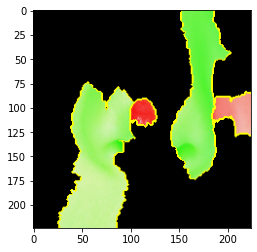

In [ ]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=True)
img_boundry2 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry2)


<Figure size 432x288 with 0 Axes>

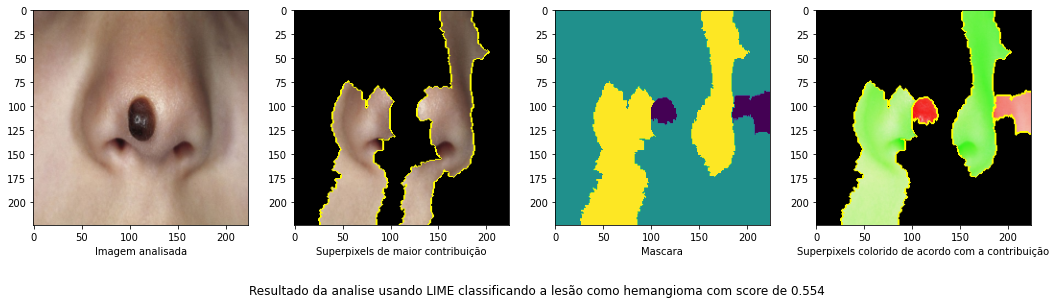

In [ ]:
plt.figure(constrained_layout=True)
#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(1,4, tight_layout = True) 
f.set_figheight(5)
f.set_figwidth(15)
# use the created array to output your multiple images. In this case I have stacked 4 images vertically
axarr[0].imshow(explanation.image)
axarr[0].set_xlabel('Imagem analisada')
axarr[1].imshow(img_boundry1)
axarr[1].set_xlabel('Superpixels de maior contribuição')
axarr[2].imshow(mask)
axarr[2].set_xlabel('Mascara')
axarr[3].imshow(img_boundry2)
axarr[3].set_xlabel('Superpixels colorido de acordo com a contribuição')
txt = 'Resultado da analise usando LIME classificando a lesão como {0} com score de {1:.3f}'.format(classes_skin[str(explanation.top_labels[0])][1], explanation.score)
plt.figtext(0.5, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=12)
#plt.savefig("/content/gdrive/My Drive/UnB/TCC-1/TCC1-1-dataset-final/intrepretabilidade_results/lime/squamous-cell-carcinoma/teste.png")
plt.show()

In [ ]:
def save_lime_imagens(explanation_image, img_boundry1, mask, img_boundry2, explanation_top_labels, explanation_score, full_output_dir, image_name):
  plt.figure(constrained_layout=True)
  #subplot(r,c) provide the no. of rows and columns
  f, axarr = plt.subplots(1,4, tight_layout = True) 
  f.set_figheight(5)
  f.set_figwidth(15)
  # use the created array to output your multiple images. In this case I have stacked 4 images vertically
  axarr[0].imshow(explanation_image)
  axarr[0].set_xlabel('Imagem analisada')
  axarr[1].imshow(img_boundry1)
  axarr[1].set_xlabel('Superpixels de maior contribuição')
  axarr[2].imshow(mask)
  axarr[2].set_xlabel('Mascara')
  axarr[3].imshow(img_boundry2)
  axarr[3].set_xlabel('Superpixels colorido de acordo com a contribuição')
  txt = 'Resultado da analise usando LIME classificando a lesão como {0} com score de {1:.3f}'.format(classes_skin[str(explanation_top_labels)][1], explanation_score)
  plt.figtext(0.5, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=12)
  path = str(full_output_dir) + "lime_" + str(image_name) + "_" + str(classes_skin[str(explanation_top_labels)][1]) + ".png"
  plt.savefig(path)
  print('Imagem salva com sucesso: ', path)
  plt.show()

In [ ]:
def create_lime_batch(img, output_dir, image_name):
  explainer = lime_image.LimeImageExplainer(verbose = True)

  explanation = explainer.explain_instance(np.array(pill_transf(img)), 
                                         batch_predict, # classification function
                                         top_labels=5, 
                                         hide_color=None, 
                                         num_samples=1000) # number of images that will be sent to classification function

  temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=10, hide_rest=True)
  img_boundry1 = mark_boundaries(temp/255.0, mask)

  temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=True)
  img_boundry2 = mark_boundaries(temp/255.0, mask)

  save_lime_imagens(explanation_image=explanation.image, img_boundry1=img_boundry1, mask=mask, img_boundry2=img_boundry2, explanation_top_labels=explanation.top_labels[0], explanation_score=explanation.score, full_output_dir=output_dir, image_name=image_name)

In [ ]:
OUTPUT_DIR_BASE = "/content/gdrive/My Drive/UnB/TCC-1/TCC1-1-dataset-final/intrepretabilidade_results/lime/pyogenic-granuloma"
INPUT_DIR_BASE = "/content/gdrive/My Drive/UnB/TCC-1/TCC1-1-dataset-final/dataset_final/test/pyogenic-granuloma"

In [ ]:
for file in list(os.listdir(INPUT_DIR_BASE)):
  file_full_path = INPUT_DIR_BASE + "/" + file
  file_output_path_base = OUTPUT_DIR_BASE + "/"  
  image_name = os.path.splitext(file)[0]

  img = get_image(file_full_path)
  print('Iniciando criação da file: ', file_full_path)
  create_lime_batch(img, file_output_path_base, image_name)

Output hidden; open in https://colab.research.google.com to view.